Importar las librerias necesarias

In [2]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import fuzzywuzzy
import re

import os
import sys  

sys.path.insert(0, "..")

from src import utils

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


In [3]:
bank_info = pd.read_csv('../bank-additional_bank-additional-full.csv', sep= ';')
# bank-additional_bank-additional-full.csv
# /Users/betancle/1- Projects/Nuclio TFM/Trabajo_Final_Master-TFM-/bank-additional_bank-additional-full.csv

In [4]:
bank_info.sample(n = 10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
5985,28,services,single,high.school,no,yes,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
10725,32,services,married,basic.9y,no,no,no,telephone,jun,tue,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
35997,31,management,married,high.school,no,yes,no,cellular,may,tue,...,1,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
13338,30,blue-collar,married,basic.9y,no,yes,no,cellular,jul,wed,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
27508,35,admin.,single,university.degree,no,no,no,cellular,nov,fri,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no
18396,35,technician,married,professional.course,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
7104,30,admin.,married,university.degree,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
5213,57,blue-collar,divorced,unknown,unknown,yes,no,telephone,may,fri,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
28938,39,management,married,basic.6y,no,yes,no,cellular,apr,fri,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
34838,35,blue-collar,single,basic.9y,no,yes,no,cellular,may,fri,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,yes


# EDA

Cúal son las variables númericas?

In [5]:
list(bank_info.select_dtypes('number').columns)

for i in list(bank_info.select_dtypes('number').columns):
    print(i)

age
duration
campaign
pdays
previous
emp.var.rate
cons.price.idx
cons.conf.idx
euribor3m
nr.employed


Cúal son las variables categoricas?

In [6]:
list(bank_info.select_dtypes('object').columns)

for i in list(bank_info.select_dtypes('object').columns):
    print(i)

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome
y


Más información sobre las columnas. 

Parece que no hay campos únicos que pueden ser identificadores.

In [7]:
bank_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Duplicados, nulos, y outliers

Usando describe() para ver información sobre los valores númericos. Hay que notar que 999 días en "pdays" es un valor nulo porque es la primera vez que contactan el cliente.

In [8]:
bank_info.describe().round(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00,41188.00
mean,40.02,258.29,2.57,962.48,0.17,0.08,93.58,-40.50,3.62,5167.04
std,10.42,259.28,2.77,186.91,0.49,1.57,0.58,4.63,1.73,72.25
min,17.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.63,4963.60
25%,32.00,102.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.34,5099.10
50%,38.00,180.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,319.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,98.00,4918.00,56.00,999.00,7.00,1.40,94.77,-26.90,5.04,5228.10


Hay duplicados. Pero porque es información categórica y la población es grande, hay una alta probabilidad que haya personas con las mismas caracteristicas.

In [9]:
bank_info[bank_info.duplicated()].sort_values(by = 'age')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
36951,45,admin.,married,university.degree,no,no,no,cellular,jul,thu,...,1,999,0,nonexistent,-2.9,92.469,-33.6,1.072,5076.2,yes
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


No hay nulos en la forma tradicional. Cada celda tiene algo.

In [10]:
bank_info.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Parece que el valor 999 tambíen está utilizado por personas que ya han sido contactados.

In [11]:
bank_info[['pdays','previous']].value_counts()

pdays  previous
999    0           35563
       1            3696
       2             349
3      1             250
6      1             220
                   ...  
13     3               1
11     4               1
2      5               1
12     4               1
999    6               1
Name: count, Length: 96, dtype: int64

Es el valor más utilizado. Hay que clarificar que significa el 999, si tambíen significa que ha sido mucho tiempo desde el último contacto.

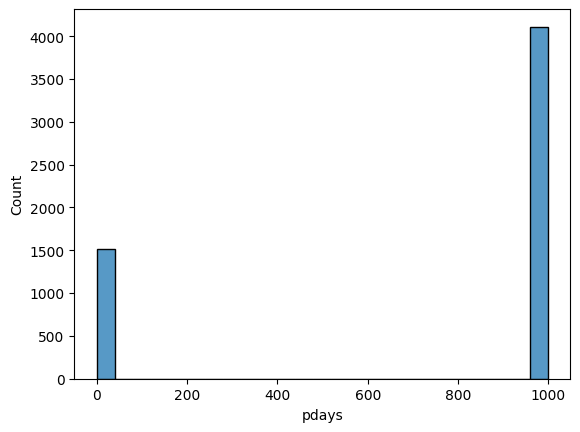

In [12]:
fig = sns.histplot(
    data=bank_info.query('previous > 0'), 
    x="pdays",
    bins= 25
    )


Hay gente que han contactado bastante, pero la gran mayoría tienen menos de 10-11 intentos.

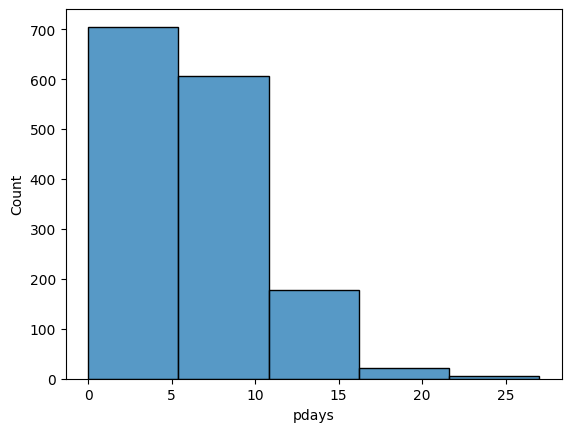

In [13]:
fig = sns.histplot(
    data=bank_info.query('previous > 0 & pdays != 999'), 
    x="pdays",
    bins= 5
    )


El máximo que no es 999 días es 27.

In [14]:
bank_info.query('pdays != 999')['pdays'].describe().round(2)

count    1515.00
mean        6.01
std         3.82
min         0.00
25%         3.00
50%         6.00
75%         7.00
max        27.00
Name: pdays, dtype: float64

Edades son valores típicas. Quízas el 17 es problematico porque legalidad, pero no se sabe eso.

In [15]:
print(bank_info['age'].value_counts())
print('-'*50)
print(bank_info.age.unique())

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64
--------------------------------------------------
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]


In [16]:
bank_info['campaign'].value_counts()

campaign
1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: count, dtype: int64

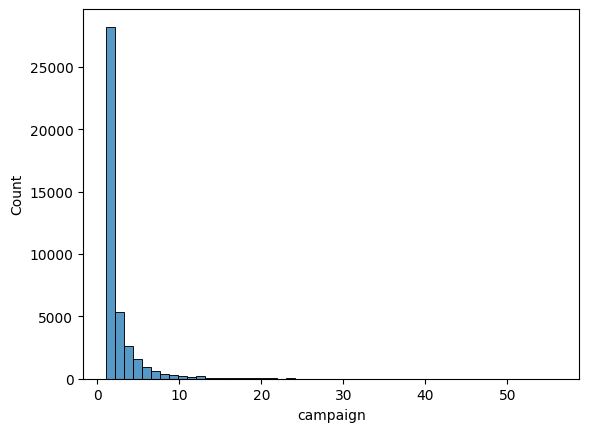

In [17]:
fig = sns.histplot(
    data=bank_info, 
    x="campaign",
    bins= 50
    )


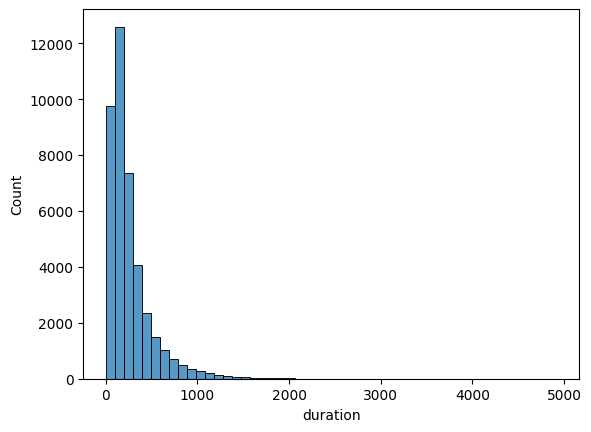

In [18]:
fig = sns.histplot(
    data=bank_info, 
    x="duration",
    bins= 50
    )


-------

#### Categoricos

In [19]:
bank_info.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [20]:
bank_info['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [21]:
bank_info['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

In [22]:
bank_info['housing'].value_counts()

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

In [23]:
bank_info['loan'].value_counts()

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

In [24]:
bank_info['marital'].value_counts()

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

-----
#### Puntos de referencia - Euribor, Empleos, etc.

In [25]:
bank_info[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].describe().round(2)

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00,41188.00,41188.00,41188.00,41188.00
mean,0.08,93.58,-40.50,3.62,5167.04
std,1.57,0.58,4.63,1.73,72.25
min,-3.40,92.20,-50.80,0.63,4963.60
25%,-1.80,93.08,-42.70,1.34,5099.10
50%,1.10,93.75,-41.80,4.86,5191.00
75%,1.40,93.99,-36.40,4.96,5228.10
max,1.40,94.77,-26.90,5.04,5228.10


In [26]:
bank_info[['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']].agg(['median']).transpose()

,median
emp.var.rate,1.100
cons.price.idx,93.749
cons.conf.idx,-41.800
euribor3m,4.857
nr.employed,5191.000


-----
-----

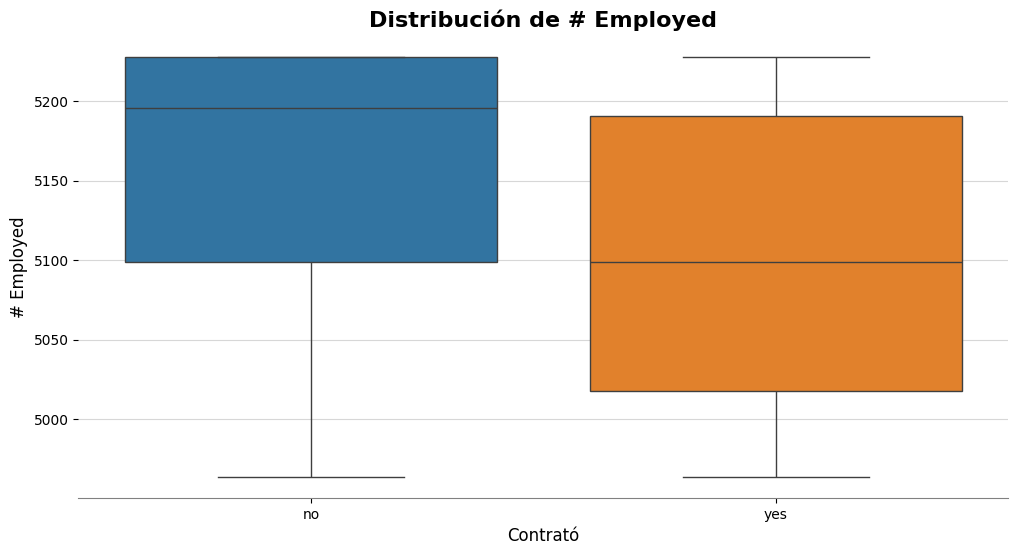

In [27]:
# TODO: configurar tamaño del plot (figsize=(12,6))
plt.figure(figsize=(12, 6))

# TODO: boxplot ventas vs mes
ax = sns.boxplot(
    data=bank_info,
    y="nr.employed",
    x="y",
    hue="y",
    legend=False
    )

# TODO: añadir título al plot y a los ejes
ax.set_title("Distribución de # Employed", fontsize=16, fontweight="bold")
ax.set_xlabel("Contrató", fontsize=12)
ax.set_ylabel("# Employed", fontsize=12)

# TODO: personalizar el grid de fondo
ax.grid(alpha=0.5, drawstyle="steps", axis="y", linestyle="-")

# TODO: personalizar el marco del plot (spines)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("gray")

# TODO: show plot
plt.show()

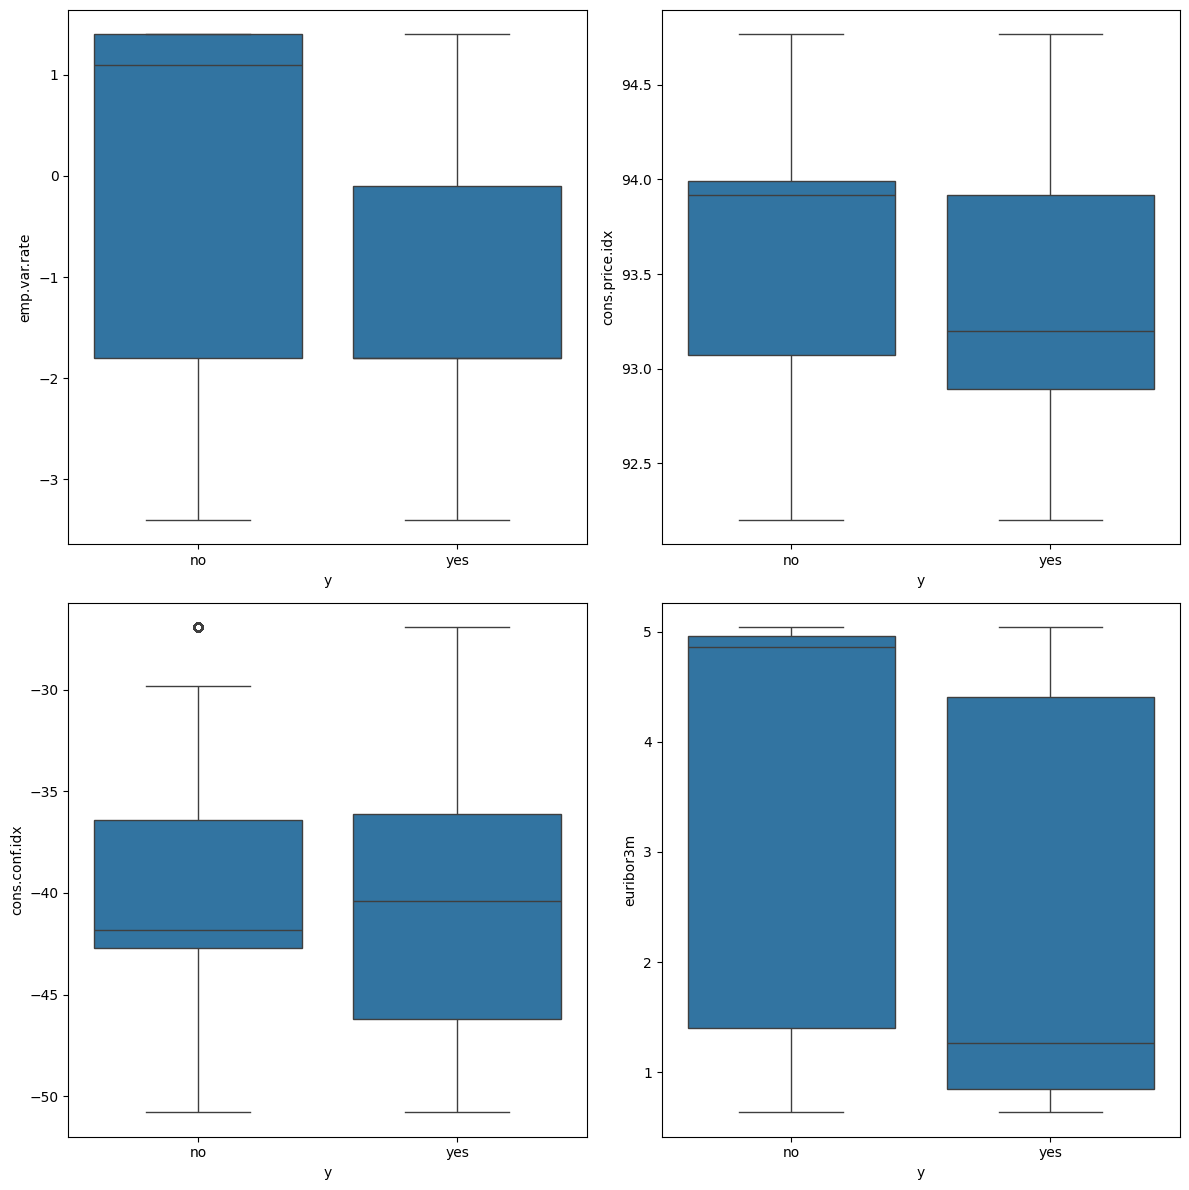

In [28]:
# TODO: iniciar el grid para el plot (3, 3, figsize=(12, 6))
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# TODO: aplanar todos los axes para poder recorrerlos todos en un solo bucle
axes_flat = axes.flatten()

# TODO: pintar cada scatterplot de forma 
lag_cols = ['emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

for i, ax in enumerate(axes_flat):
    sns.boxplot(
        data=bank_info,
        y=lag_cols[i],
        x="y",
        legend=False,
        ax=ax,  # pintamos sobre un ax ya existente
        )
    
# TODO: ajustar espacio entre plots
plt.tight_layout()

## Analisis de datos

### Empleos

Cúales tipos de empleos tienen las personas contactadas, y cúanta gente en total hay en cada grupo?

In [29]:
bank_info.groupby('job')['y'].count().reset_index().rename({'y':'contacts'}, axis = 'columns').sort_values(by = 'contacts', ascending= False)

,job,contacts
0,admin.,10422
1,blue-collar,9254
9,technician,6743
7,services,3969
4,management,2924
5,retired,1720
2,entrepreneur,1456
6,self-employed,1421
3,housemaid,1060
10,unemployed,1014


<Axes: xlabel='y', ylabel='job'>

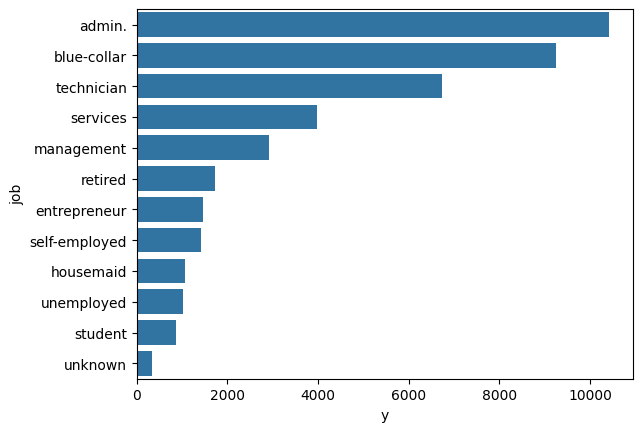

In [30]:
bank_info.groupby('job')['y'].count()

# bank_info.groupby('job')['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= 'job', columns = 'y', values = 'proportion')

sns.barplot(
    bank_info.groupby('job')['y'].count().reset_index().sort_values(by = 'y', ascending= False),
    x = 'y',
    y = 'job'
)

# euribor3m	

Qué es la proporción de gente que dijó "Sí" basado a nuestro contacto, por trabajo?

In [31]:
bank_info.groupby('job')['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= 'job', columns = 'y', values = 'proportion')

y,no,yes
job,,
admin.,0.87,0.13
blue-collar,0.93,0.07
entrepreneur,0.91,0.09
housemaid,0.90,0.10
management,0.89,0.11
retired,0.75,0.25
self-employed,0.90,0.10
services,0.92,0.08
student,0.69,0.31


[Text(0, 0, '0.31'),
 Text(0, 0, '0.25'),
 Text(0, 0, '0.14'),
 Text(0, 0, '0.13'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.09'),
 Text(0, 0, '0.08'),
 Text(0, 0, '0.07')]

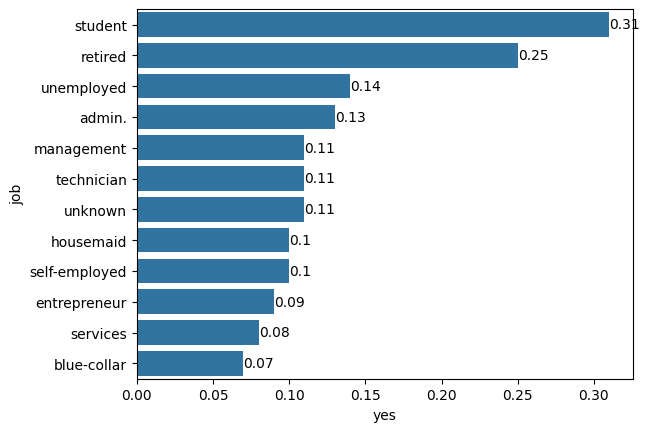

In [67]:
# bank_info.groupby('job')['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= 'job', columns = 'y', values = 'proportion')

ax = sns.barplot(
    bank_info.groupby('job')['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= 'job', columns = 'y', values = 'proportion').sort_values(by = 'yes', ascending= False),
    x = 'yes',
    y = 'job'
)

ax.bar_label(ax.containers[0], fontsize=10)


In [35]:
# Creando un nuevo campo.
bank_info['job_type'] = bank_info['job'].apply(lambda x: utils.jobType(x))


In [62]:
print(bank_info.groupby('job_type')['y'].count())
print('--'*20)
print(bank_info['job_type'].value_counts(normalize= True).round(2))
print('--'*20)
print(bank_info.query('y == "yes"')['job_type'].value_counts(normalize = True).round(2))

job_type
No Job or Retired     3609
Office Job           17315
Physical Job         17057
Self-Employed         2877
Unknown                330
Name: y, dtype: int64
----------------------------------------
job_type
Office Job           0.42
Physical Job         0.41
No Job or Retired    0.09
Self-Employed        0.07
Unknown              0.01
Name: proportion, dtype: float64
----------------------------------------
job_type
Office Job           0.43
Physical Job         0.32
No Job or Retired    0.18
Self-Employed        0.06
Unknown              0.01
Name: proportion, dtype: float64


[Text(0, 0, '0.24'),
 Text(0, 0, '0.12'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.09'),
 Text(0, 0, '0.09')]

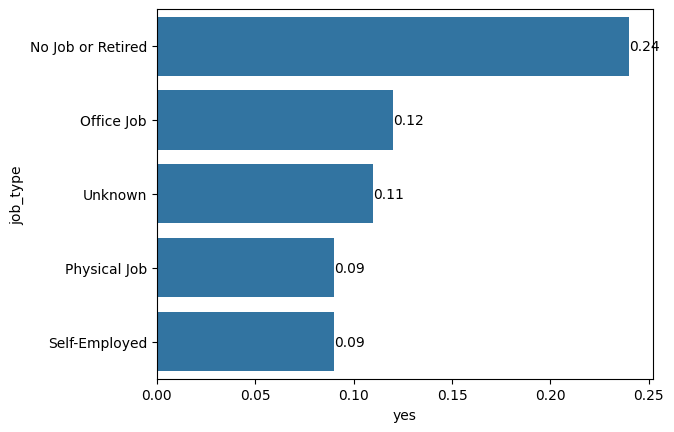

In [66]:
ax = sns.barplot(
    bank_info.groupby('job_type')['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= 'job_type', columns = 'y', values = 'proportion').sort_values(by = 'yes', ascending= False),
    x = 'yes',
    y = 'job_type'
)

ax.bar_label(ax.containers[0], fontsize=10)


### Educación

In [63]:
print(bank_info.groupby('education_type')['y'].count())
print('--'*20)
print(bank_info['education_type'].value_counts(normalize= True).round(2))
print('--'*20)
print(bank_info.query('y == "yes"')['education_type'].value_counts(normalize = True).round(2))

education_type
Basic Education (Yr 4-9)              12513
High School                            9515
University or Professional Program    17411
Unknown or Illiterate                  1749
Name: y, dtype: int64
----------------------------------------
education_type
University or Professional Program    0.42
Basic Education (Yr 4-9)              0.30
High School                           0.23
Unknown or Illiterate                 0.04
Name: proportion, dtype: float64
----------------------------------------
education_type
University or Professional Program    0.49
Basic Education (Yr 4-9)              0.23
High School                           0.22
Unknown or Illiterate                 0.05
Name: proportion, dtype: float64


[Text(0, 0, '0.22'),
 Text(0, 0, '0.15'),
 Text(0, 0, '0.14'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.08'),
 Text(0, 0, '0.08')]

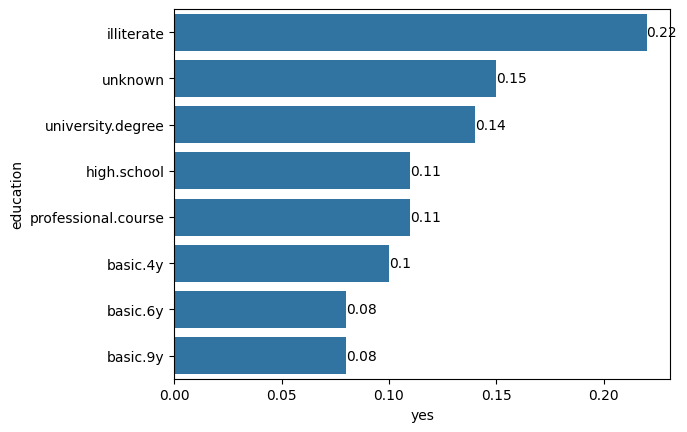

In [ ]:
ax = sns.barplot(
    bank_info.groupby('education')['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= 'education', columns = 'y', values = 'proportion').sort_values(by = 'yes', ascending= False),
    x = 'yes',
    y = 'education'
)

ax.bar_label(ax.containers[0], fontsize=10)



In [39]:
# Creando un campo para analisar tipo de educación.
bank_info['education_type'] = bank_info['education'].apply(lambda x: utils.educationType(x))


[Text(0, 0, '0.15'),
 Text(0, 0, '0.09'),
 Text(0, 0, '0.11'),
 Text(0, 0, '0.13')]

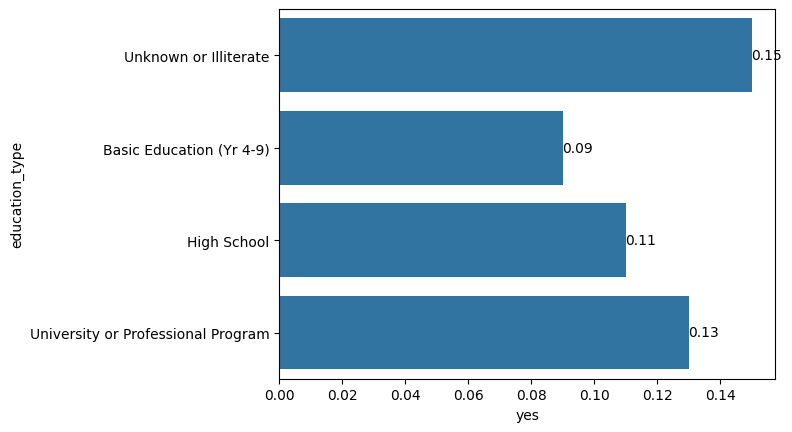

In [94]:
ax = sns.barplot(
    bank_info.groupby('education_type')['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= 'education_type', columns = 'y', values = 'proportion').sort_values(by = 'yes', ascending= False),
    x = 'yes',
    y = 'education_type',
        order= ['Unknown or Illiterate','Basic Education (Yr 4-9)','High School','University or Professional Program']
)

ax.bar_label(ax.containers[0], fontsize=10)


In [82]:
 bank_info.groupby(['job','education_type'])['y'].value_counts(normalize= True).round(2).reset_index().query('y == "yes" & job == "retired"')

,job,education_type,y,proportion
41,retired,Basic Education (Yr 4-9),yes,0.26
43,retired,High School,yes,0.22
45,retired,University or Professional Program,yes,0.23
47,retired,Unknown or Illiterate,yes,0.35


<Axes: xlabel='education_type', ylabel='proportion'>

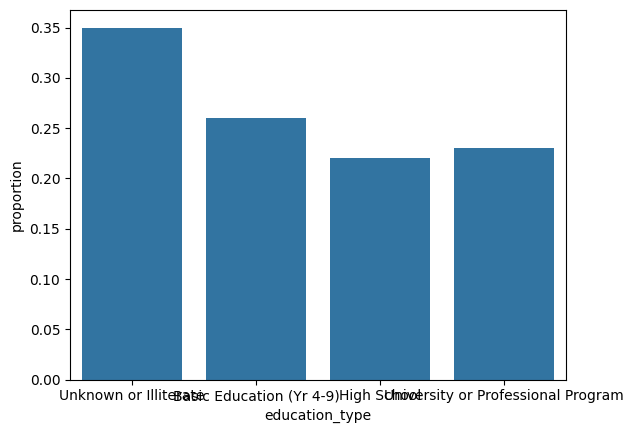

In [93]:
sns.barplot(
    bank_info.groupby(['job','education_type'])['y'].value_counts(normalize= True).round(2).reset_index().query('y == "yes" & job == "retired"'), 
    x="education_type", 
    y="proportion",
    order= ['Unknown or Illiterate','Basic Education (Yr 4-9)','High School','University or Professional Program']
    )

In [ ]:
bank_info.euribor3m.describe()

count    41188.000000
mean         3.621291
std          1.734447
min          0.634000
25%          1.344000
50%          4.857000
75%          4.961000
max          5.045000
Name: euribor3m, dtype: float64

In [ ]:
import numpy as np

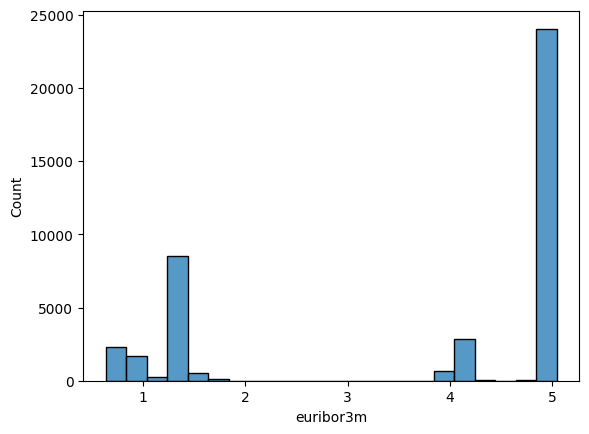

In [ ]:
fig = sns.histplot(
    data=bank_info, 
    x="euribor3m"
    )


In [ ]:
bank_info.groupby('euribor3m_segment')['y'].count()

/var/folders/4k/9hthz5210ms6_s09wx9tymvw0000gn/T/ipykernel_40020/1731829553.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank_info.groupby('euribor3m_segment')['y'].count()


euribor3m_segment
0-2        13498
2-3            0
3-4.5       3603
4.5-5.5    24087
Name: y, dtype: int64

In [ ]:
bank_info.groupby('euribor3m_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'euribor3m_segment', columns = 'y', values = 'proportion').round(2)

/var/folders/4k/9hthz5210ms6_s09wx9tymvw0000gn/T/ipykernel_40020/3512428722.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank_info.groupby('euribor3m_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'euribor3m_segment', columns = 'y', values = 'proportion').round(2)


y,no,yes
euribor3m_segment,,
<1,0.54,0.46
1-3,0.84,0.16
3-6,0.95,0.05


/var/folders/4k/9hthz5210ms6_s09wx9tymvw0000gn/T/ipykernel_40020/3430630524.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank_info.groupby('euribor3m_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'euribor3m_segment', columns = 'y', values = 'proportion').query('no > 0.01'),


"\nbins = [0, 2, 18, 35, 65, np.inf]\nnames = ['<2', '2-18', '18-35', '35-65', '65+']\n\n\n\nprint(df.dtypes)\n\n# Age             int64\n# Age_units      object\n# AgeRange     category\n# dtype: object\n\n"

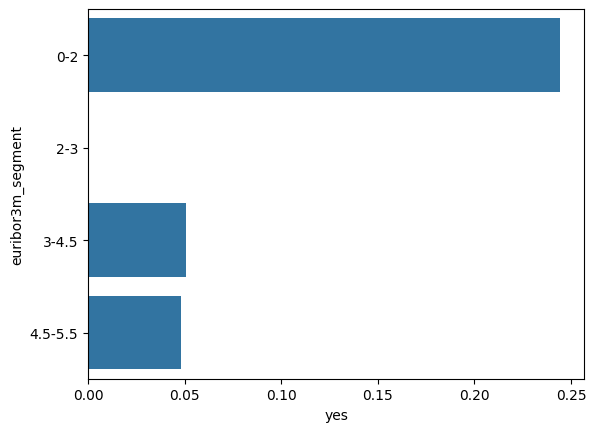

In [ ]:
bins = [0, 2, 3, 4.5, 5.5]
names = ['0-2', '2-3', '3-4.5', '4.5-5.5']

bank_info['euribor3m_segment'] = pd.cut(bank_info['euribor3m'], bins, labels=names)

sns.barplot(
    bank_info.groupby('euribor3m_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'euribor3m_segment', columns = 'y', values = 'proportion'),
    x = 'yes',
    y = 'euribor3m_segment'
)


"""
bins = [0, 2, 18, 35, 65, np.inf]
names = ['<2', '2-18', '18-35', '35-65', '65+']



print(df.dtypes)

# Age             int64
# Age_units      object
# AgeRange     category
# dtype: object

"""

/var/folders/4k/9hthz5210ms6_s09wx9tymvw0000gn/T/ipykernel_40020/1721522766.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank_info.groupby('euribor3m_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'euribor3m_segment', columns = 'y', values = 'proportion'),


<Axes: xlabel='euribor3m_segment', ylabel='yes'>

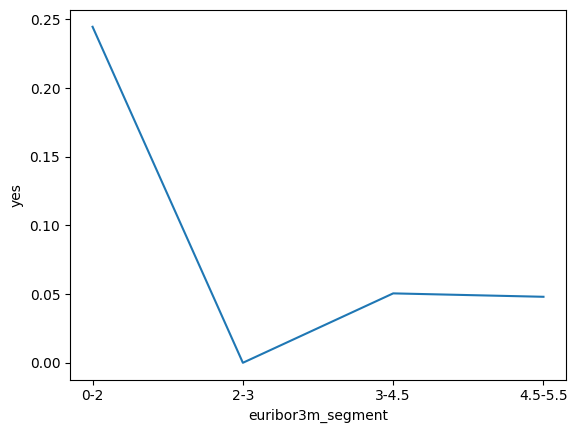

In [ ]:
sns.lineplot(
    bank_info.groupby('euribor3m_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'euribor3m_segment', columns = 'y', values = 'proportion'),
    x = 'euribor3m_segment',
    y = 'yes'
)


In [ ]:
bank_info.groupby(['job','contact'])['y'].value_counts(normalize= True).round(2).reset_index()

,job,contact,y,proportion
0,admin.,cellular,no,0.84
1,admin.,cellular,yes,0.16
2,admin.,telephone,no,0.94
3,admin.,telephone,yes,0.06
4,blue-collar,cellular,no,0.91
5,blue-collar,cellular,yes,0.09
6,blue-collar,telephone,no,0.96
7,blue-collar,telephone,yes,0.04
8,entrepreneur,cellular,no,0.90
9,entrepreneur,cellular,yes,0.10


<Axes: xlabel='yes', ylabel='job'>

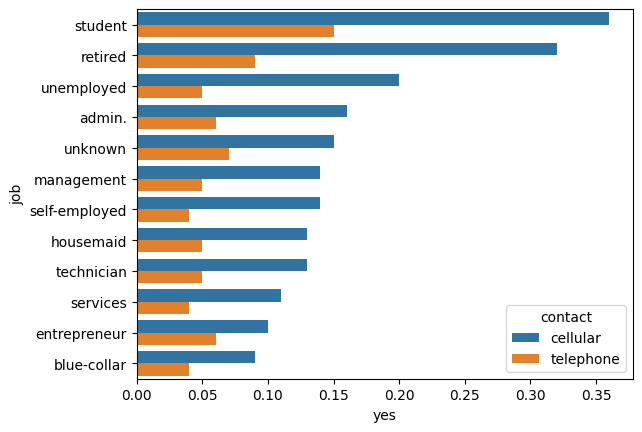

In [ ]:
sns.barplot(
    bank_info.groupby(['job','contact'])['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= ['job','contact'], columns = 'y', values = 'proportion').sort_values(by = 'yes', ascending= False),
    x = 'yes',
    y = 'job',
    hue = 'contact'
)

<Axes: xlabel='yes', ylabel='education'>

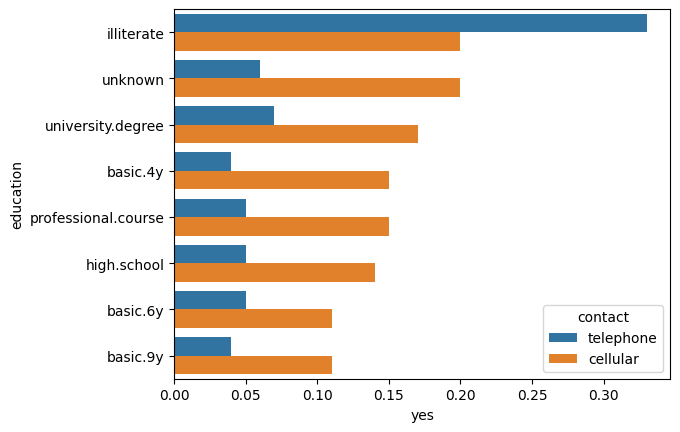

In [ ]:
sns.barplot(
    bank_info.groupby(['education','contact'])['y'].value_counts(normalize= True).round(2).reset_index().pivot(index= ['education','contact'], columns = 'y', values = 'proportion').sort_values(by = 'yes', ascending= False),
    x = 'yes',
    y = 'education',
    hue = 'contact'
)

/var/folders/4k/9hthz5210ms6_s09wx9tymvw0000gn/T/ipykernel_40020/1886086254.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank_info.groupby('age_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'age_segment', columns = 'y', values = 'proportion'),


<Axes: xlabel='yes', ylabel='age_segment'>

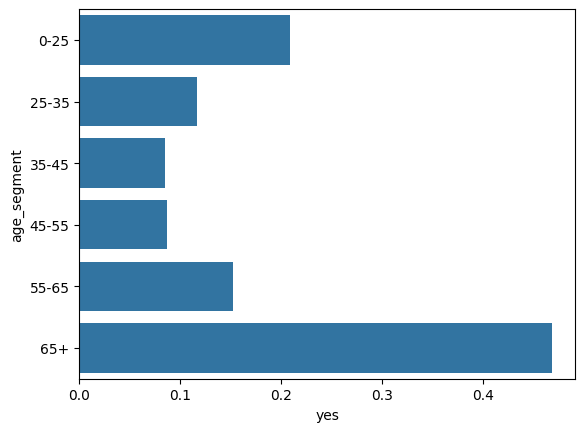

In [ ]:
bins = [0,25, 35, 45, 55, 65, np.inf]
names = ['0-25', '25-35', '35-45', '45-55','55-65','65+']

bank_info['age_segment'] = pd.cut(bank_info['age'], bins, labels=names)

sns.barplot(
    bank_info.groupby('age_segment')['y'].value_counts(normalize= True).reset_index().pivot(index= 'age_segment', columns = 'y', values = 'proportion'),
    x = 'yes',
    y = 'age_segment'
)

In [ ]:
bank_info.groupby('age_segment')['y'].count()

/var/folders/4k/9hthz5210ms6_s09wx9tymvw0000gn/T/ipykernel_40020/3121775786.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank_info.groupby('age_segment')['y'].count()


age_segment
0-25      1666
25-35    14847
35-45    12844
45-55     8249
55-65     2963
65+        619
Name: y, dtype: int64